<a href="https://colab.research.google.com/github/FinOloughlin/CITS4403-Black-Death/blob/main/Copy_of_Black_Death.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import numpy as np

In [3]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

Downloaded utils.py
Downloaded Cell2D.py


In [4]:
from utils import decorate, savefig
# make a directory for figures
!mkdir -p figs

In [5]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.7.5-py3-none-any.whl size=12469 sha256=b45a2e128c60dfdf6e16297a4e3aaa41319f63996ba9e7b3a06b332c367c058c
  Stored in directory: /root/.cache/pip/wheels/0d/d0/ae/1ad4c7593703e55b2321b23b49d3b0d55261b59d7036d7045b
Successfully built empiricaldist


### !! Mesa documentation: https://mesa.readthedocs.io/stable/

In [6]:
!pip install mesa

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.1 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.7/425.7 kB 11.9 MB/s eta 0:00

# Black Death

In [14]:
class PlagueAgent(Agent):
  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.health_status = "Susceptible"
    self.age = self.random.randrange(1,80)
    self.days_infected = 0
    self.recovered = False
    self.dead = False

  def step(self):
    self.try_random_infection()

    if self.health_status == "Infected":
      self.days_infected += 1
      if self.days_infected >= 4:
        self.check_recovery_or_death()

      self.spread_disease()

    self.move()

  def spread_disease(self):
    infection_chance = 0.9

    neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)

    for neighbor in neighbors:
      if isinstance(neighbor, PlagueAgent) and neighbor.health_status == "Susceptible":
        if self.random.random() < infection_chance:
          neighbor.health_status = "Infected"

  def try_random_infection(self):
    chance = 0.05
    if self.health_status == "Susceptible" and self.random.random() < chance:
      self.health_status = "Infected"

  def check_recovery_or_death(self):
    if self.age < 30:
      recovery_chance = 0.4
    elif 30 <= self.age <= 50:
      recovery_chance = 0.3
    else:
      recovery_chance = 0.2

    if self.age < 30:
      death_chance = 0.4
    elif 30 <= self.age <= 50:
      death_chance = 0.6
    else:
      death_chance = 0.8

    if not self.recovered and not self.dead:
      if self.random.random() < recovery_chance:
        self.recovered = True
        self.health_status = "Recovered"

    if not self.recovered and not self.dead:
      if self.random.random() < death_chance:
        self.dead = True
        self.health_status = "Dead"

  def move(self):

    if self.health_status == "Dead":
      return

    x, y = self.pos

    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            new_x = x + dx
            new_y = y + dy
            if 0 <= new_x < self.model.grid.width and 0 <= new_y < self.model.grid.height:
                neighbors.append((new_x, new_y))

    if neighbors:
        new_position = self.random.choice(neighbors)
        self.model.grid.move_agent(self, new_position)


class PlagueModel(Model):
  def __init__(self, width, height, num_agents):
        super().__init__()
        self.num_agents = num_agents
        self.height = height
        self.width = width
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        self.create_agents()

  def create_agents(self):
        for i in range(self.num_agents):
          agent = PlagueAgent(i, self)
          self.schedule.add(agent)

          x = self.random.randrange(self.grid.width)
          y = self.random.randrange(self.grid.height)
          self.grid.place_agent(agent, (x,y))

  def step(self):
    self.schedule.step()

  def plot_agents(self):
    grid = np.zeros((self.grid.height,self.grid.width))

    for cell in self.grid.coord_iter():
      cell_content,(x,y) = cell

      if len(cell_content) > 0:
        agent = cell_content[0]
        if agent.health_status == "Susceptible":
          grid[x][y] = 1
        elif agent.health_status == "Infected":
          grid[x][y] = 2
        elif agent.health_status == "Recovered":
          grid[x][y] = 3
        elif agent.health_status == "Dead":
          grid[x][y] = 4

    custom_colours=["white","blue","red","green","black"]
    cmap = mcolors.ListedColormap(custom_colours)

    plt.imshow(grid,cmap=cmap,interpolation="nearest",vmin=0,vmax=5)
    plt.title("Black Plague")
    plt.show()


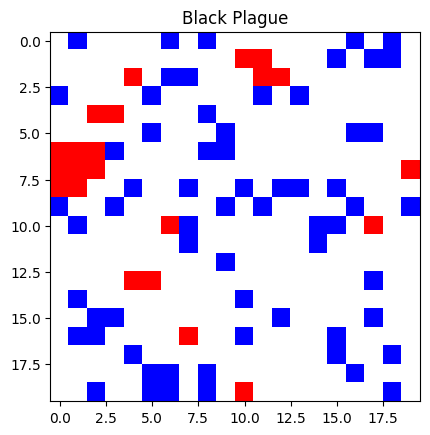

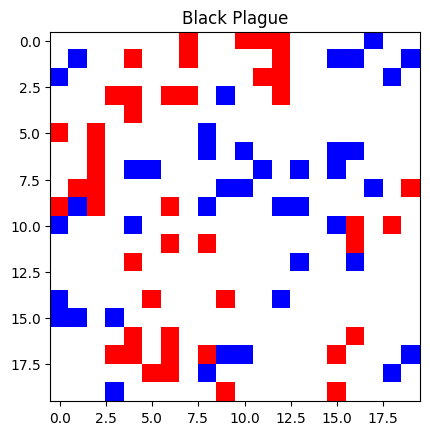

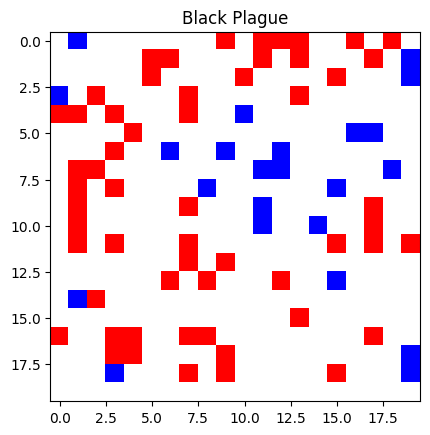

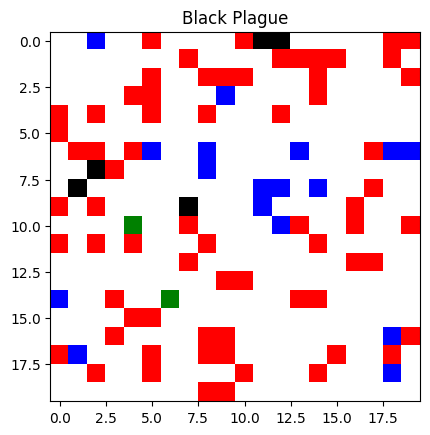

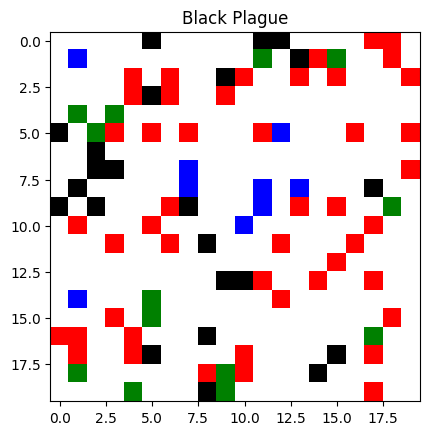

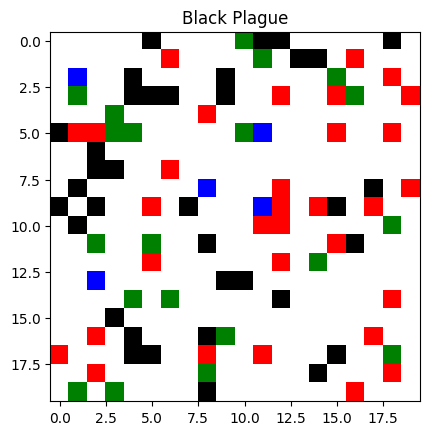

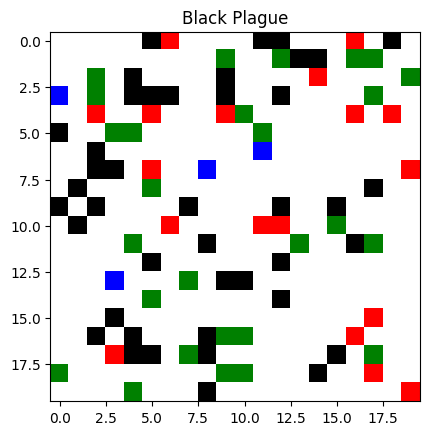

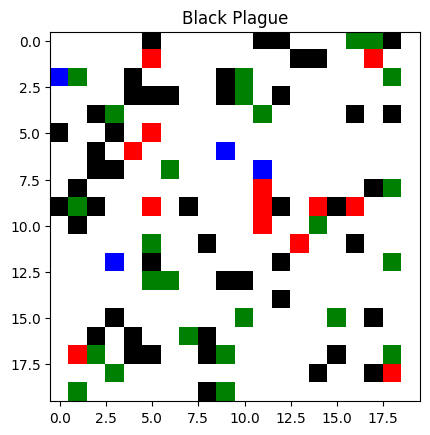

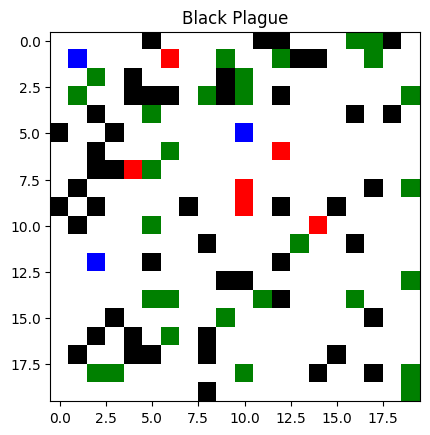

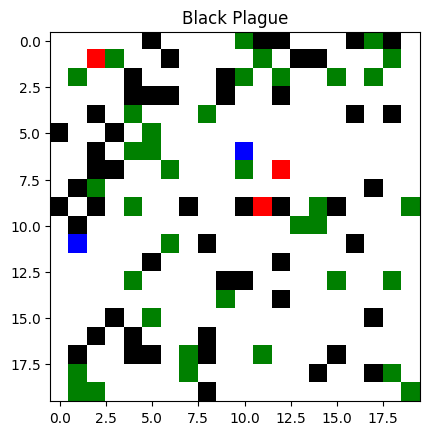

In [16]:
model = PlagueModel(width=20, height=20, num_agents=100)

for i in range(10):
  model.step()
  model.plot_agents()
